# Bootstrap validation

This notebook contains code for validating the approximate bootstrap as well as generating half of figure 3 of the paper.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
# pd.set_option('display.max_colwidth', -1)
from statsmodels.distributions.empirical_distribution import ECDF
import pickle as pkl
import time

import sklearn.datasets as sklearn_datasets
import scipy.sparse as sparse


/tmp/ipykernel_44975/192257472.py:11: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
import memento
import memento.simulate as simulate

In [4]:
# import sys
# sys.path.append('/home/ssm-user/Github/single_cell_eb/')
# sys.path.append('/home/ssm-user/Github/single_cell_eb/sceb')
# import scdd

In [5]:
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig3/'
DATA_PATH = '/home/ubuntu/Data/'
data_path = DATA_PATH
CELL_TYPE = 'CD4 T cells - ctrl'
num_cell = 10000
q=0.07
NUM_CORR_GENES = 300 # First hundred genes display correlation


### Get parameters from real data

In [6]:
def get_simulation_parameters(q=0.07):
    """ Extracts simulation parameters. """
    
    adata = sc.read(DATA_PATH + 'interferon_filtered.h5ad')
    adata = adata[adata.obs.cell_type == CELL_TYPE]
    data = adata.X.copy()
    relative_data = data.toarray()/data.sum(axis=1)
    
    x_param, z_param, Nc, good_idx = simulate.extract_parameters(adata.X, q=q, min_mean=0.01)
    
    return x_param, z_param, Nc


def simulate_data(n_cells, z_param, Nc):
    """ Generates simulated data. """
    
    # Generate ground truth data
    cov_matrix = sklearn_datasets.make_spd_matrix(NUM_CORR_GENES)
    true_data = simulate.simulate_transcriptomes(n_cells=n_cells, means=z_param[0], variances=z_param[1], Nc=Nc, norm_cov=cov_matrix)
    true_data[true_data < 0] = 0
    
    # Sample transcripts
    qs, captured_data = simulate.capture_sampling(true_data, q, q_sq=None)

    # Filter cells
    cell_filter = captured_data.sum(axis=1) > 0
    gene_filter = captured_data.sum(axis=0) > 0
    true_data = true_data[cell_filter, :][:, gene_filter]
    captured_data = captured_data[cell_filter, :][:, gene_filter]
    
    captured_data = sparse.csr_matrix(captured_data)
    true_data = sparse.csr_matrix(true_data)
    return true_data, captured_data, int(gene_filter[:NUM_CORR_GENES].sum())

In [7]:
x_param, z_param, Nc = get_simulation_parameters(q=0.07)


/home/ubuntu/anaconda3/envs/mementocxg/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [8]:
test_gene_means = np.quantile(x_param[0][:NUM_CORR_GENES], np.linspace(0.05, 0.95, 10))

In [9]:
def idxquantile(s, q=0.5, *args, **kwargs):
    qv = s.quantile(q, *args, **kwargs)
    return (s.sort_values()[::-1] <= qv).idxmax()

In [10]:
test_gene_idxs = np.array([idxquantile(pd.Series(x_param[0][:NUM_CORR_GENES]), q) for q in np.linspace(0.05, 0.95, 10)])

### Simulate some cells

10K cells for ~2k genes

In [11]:
# # Simulate 10K cells for 10K genes

# x_param, z_param, Nc, good_idx = simulate.extract_parameters(adata.X, q=q, min_mean=q)

# simulated_data = simulate.simulate_transcriptomes(
#     n_cells=n_cells, 
#     means=z_param[0],
#     variances=z_param[1],
#     Nc=Nc,
#     norm_cov='uncorrelated')

# # with open('simulated_data.pkl', 'wb') as f:
# #     pkl.dump(simulated_data, f)

In [ ]:
num_boot = 5000
results = []
for trial in range(20):
    
    true_data, captured_data, filtered_num_corr_genes = simulate_data(num_cell, z_param, Nc)
    size_factor = captured_data.sum(axis=1).A1
    adata = sc.AnnData(captured_data)
    
    for ii in range(test_gene_idxs.shape[0]-1):
        
        gene_idx_1 = test_gene_idxs[ii]
        gene_idx_2 = test_gene_idxs[ii]+1
        
        data_1 = adata.X[:, gene_idx_1].todense().A1
        sparse_data_1 = adata.X[:, gene_idx_1]
        unique_count_1 = np.unique(data_1).shape[0]
        
        data_2 = adata.X[:, gene_idx_2].todense().A1
        sparse_data_2 = adata.X[:, gene_idx_2]
        unique_count_2 = np.unique(data_2).shape[0]
        
        real_boot_mean_dist = np.zeros(num_boot)
        real_boot_var_dist = np.zeros(num_boot)
        real_boot_corr_dist = np.zeros(num_boot)

        # do real bootstrap
        for boot in range(num_boot):

            boot_idx = np.random.choice(data_1.shape[0], data_1.shape[0])
            res1 = memento.estimator._hyper_1d_relative(sparse_data_1[boot_idx], data_1.shape[0], size_factor=size_factor[boot_idx], q=q)
            res2 = memento.estimator._hyper_1d_relative(sparse_data_2[boot_idx], data_2.shape[0], size_factor=size_factor[boot_idx], q=q)
            cov = memento.estimator._hyper_cov_relative(
                sp.sparse.hstack([sparse_data_1[boot_idx], sparse_data_2[boot_idx]], format='csr'), data_2.shape[0], size_factor=size_factor[boot_idx], q=q,
                idx1= np.array([0]), idx2=np.array([1]))

            real_boot_mean_dist[boot] = res1[0][0]
            real_boot_var_dist[boot] = res1[1][0]/res1[0][0]**2
            real_boot_corr_dist[boot] = cov[0]/np.sqrt(res1[1][0]*res2[1][0])
            
        # do memento bootstrap
        num_bins=60
        binned_stat = stats.binned_statistic(size_factor, size_factor, bins=num_bins, statistic='mean')
        bin_idx = np.clip(binned_stat[2], a_min=1, a_max=binned_stat[0].shape[0])
        approx_sf = binned_stat[0][bin_idx-1]
        max_sf = size_factor.max()
        approx_sf[size_factor == max_sf] = max_sf

        mean_emd_score = 0
        var_emd_score = 0
        corr_emd_score = 0

        m1, v1 = memento.bootstrap._bootstrap_1d(
            data=sparse_data_1,
            size_factor=approx_sf, 
            num_boot=num_boot,
            q=q,
            _estimator_1d=memento.estimator._hyper_1d_relative)
        
        rv = v1/m1**2

        cov1, v1, v2 = memento.bootstrap._bootstrap_2d(
            data=sp.sparse.hstack([sparse_data_1, sparse_data_2], format='csr'),
            size_factor=approx_sf, 
            num_boot=num_boot,
            q=q,
            _estimator_1d=memento.estimator._hyper_1d_relative,
            _estimator_cov=memento.estimator._hyper_cov_relative)
        
        simulation_result = (ii, real_boot_mean_dist, real_boot_var_dist, real_boot_corr_dist, m1, rv, cov1/np.sqrt(v1*v2))
        results.append(simulation_result)

with open('simulation_result.pkl', 'wb') as f:
    
    pkl.dump(results, f)

/home/ubuntu/Github/scrna-parameter-estimation/memento/simulate.py:81: RuntimeWarning: invalid value encountered in divide
  relative_transcriptome = nbinom_variables/nbinom_variables.sum(axis=1).reshape(-1,1)
/home/ubuntu/Github/scrna-parameter-estimation/memento/simulate.py:82: RuntimeWarning: invalid value encountered in multiply
  transcriptome = relative_transcriptome*cell_sizes
/home/ubuntu/Github/scrna-parameter-estimation/memento/simulate.py:84: RuntimeWarning: invalid value encountered in cast
  return np.round(transcriptome).astype(int)


In [25]:
def summarize(estimate_idx): #0 for mean, 1 for var, and 2 for corr
    
    estimate_results = []
    result_idx = 0
    for trial in range(20):



        for ii in range(test_gene_idxs.shape[0]-1) :

            r = results[result_idx]
            estimate_results.append((
                trial,
                ii,
                test_gene_means[ii],
                stats.ks_2samp(np.log(r[estimate_idx+1]), np.log(r[estimate_idx+4]))[1],
                ))
            result_idx += 1
    estimate_results = pd.DataFrame(estimate_results, columns=['trial', 'gene_idx','gene_mean', 'ks_pval'])

    return estimate_results

/tmp/ipykernel_44975/3390482919.py:16: RuntimeWarning: invalid value encountered in log
  stats.ks_2samp(np.log(r[estimate_idx+1]), np.log(r[estimate_idx+4]))[1],
/tmp/ipykernel_44975/3390482919.py:16: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  stats.ks_2samp(np.log(r[estimate_idx+1]), np.log(r[estimate_idx+4]))[1],
/tmp/ipykernel_44975/3390482919.py:16: RuntimeWarning: invalid value encountered in log
  stats.ks_2samp(np.log(r[estimate_idx+1]), np.log(r[estimate_idx+4]))[1],
/tmp/ipykernel_44975/3390482919.py:16: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  stats.ks_2samp(np.log(r[estimate_idx+1]), np.log(r[estimate_idx+4]))[1],


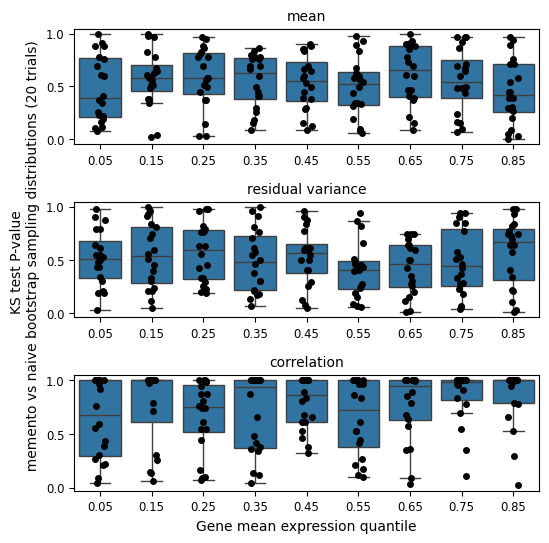

In [39]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.5)
plt.subplot(3,1,1)
sns.boxplot(x='gene_idx', y='ks_pval', data=summarize(0),fliersize=0);
sns.stripplot(x='gene_idx', y='ks_pval', data=summarize(0),color='k');

plt.xticks(np.arange(9), np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85]));
plt.ylabel(None)
plt.title('mean')
plt.xlabel(None)


plt.subplot(3,1,2)
sns.boxplot(x='gene_idx', y='ks_pval', data=summarize(1),fliersize=0);
sns.stripplot(x='gene_idx', y='ks_pval', data=summarize(1),color='k');

plt.xticks(np.arange(9), np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85]));
plt.ylabel('KS test P-value \n  memento vs naive bootstrap sampling distributions (20 trials)')
plt.title('residual variance')
plt.xlabel(None)


plt.subplot(3,1,3)
sns.boxplot(x='gene_idx', y='ks_pval', data=summarize(2),fliersize=0);
sns.stripplot(x='gene_idx', y='ks_pval', data=summarize(2),color='k');

plt.xticks(np.arange(9), np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85]));
plt.xlabel('Gene mean expression quantile')
plt.title('correlation')

plt.ylabel(None)
plt.savefig('bootstrap_ks_box.png', bbox_inches='tight', dpi=300)

In [30]:
stats.ks_2samp(real_m, mem_m)[1]

0.963973606015013

<Axes: ylabel='Density'>

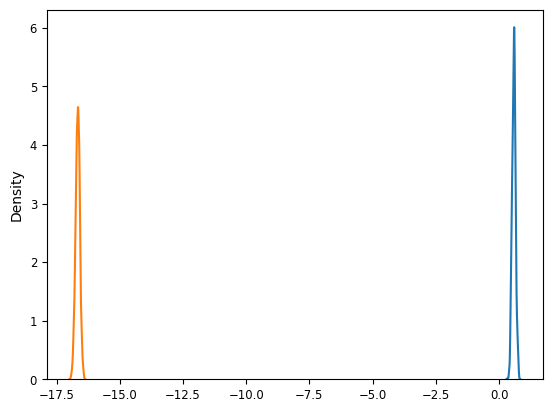

In [114]:
sns.kdeplot(np.log(results[0][1]))
sns.kdeplot(np.log(results[0][4]))

In [38]:
hyper_captured = captured_data
# with open('captured_data.pkl', 'wb') as f:
#     pkl.dump(hyper_captured, f)

In [39]:
adata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))


### Compare the approximate bootstrap to the true bootstrap

In [59]:
size_factor = memento.estimator._estimate_size_factor(hyper_captured, 'relative', shrinkage=0, total=True)

This gene has 3 unique counts.
This gene has 3 unique counts.
This gene has 3 unique counts.


(array([9.694e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.930e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

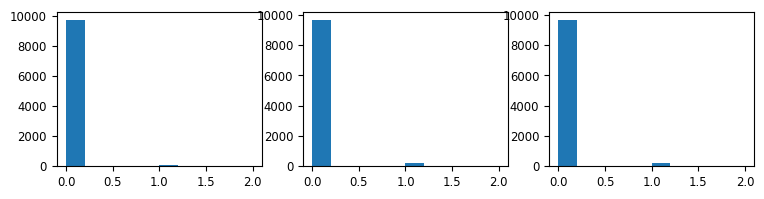

In [63]:
# Get info for a single gene
gene_idx_1 = 9
data_1 = adata.X[:, gene_idx_1].todense().A1
sparse_data_1 = adata.X[:, gene_idx_1]
unique_count_1 = np.unique(data_1).shape[0]

gene_idx_2 = 30
data_2 = adata.X[:, gene_idx_2].todense().A1
sparse_data_2 = adata.X[:, gene_idx_2]
unique_count_2 = np.unique(data_2).shape[0]

gene_idx_3 = 90
data_3 = adata.X[:, gene_idx_3].todense().A1
sparse_data_3 = adata.X[:, gene_idx_3]
unique_count_3 = np.unique(data_3).shape[0]

num_boot = 1000
print('This gene has {} unique counts.'.format(unique_count_1))
print('This gene has {} unique counts.'.format(unique_count_2))
print('This gene has {} unique counts.'.format(unique_count_3))


plt.figure(figsize=(9, 2))
plt.subplot(1, 3, 1); plt.hist(data_1)
plt.subplot(1, 3, 2); plt.hist(data_2)
plt.subplot(1, 3, 3); plt.hist(data_3)

### Compare true and approximate bootstrap

In [65]:
%%time
# Perform true bootstrap
real_boot_mean_dist = np.zeros(num_boot)
real_boot_var_dist = np.zeros(num_boot)
real_boot_corr_dist = np.zeros(num_boot)

for boot in range(num_boot):
    
    boot_idx = np.random.choice(data_1.shape[0], data_1.shape[0])
    res1 = memento.estimator._hyper_1d_relative(sparse_data_1[boot_idx], data_1.shape[0], size_factor=size_factor[boot_idx], q=q)
    res2 = memento.estimator._hyper_1d_relative(sparse_data_2[boot_idx], data_2.shape[0], size_factor=size_factor[boot_idx], q=q)
    cov = memento.estimator._hyper_cov_relative(
        sp.sparse.hstack([sparse_data_1[boot_idx], sparse_data_2[boot_idx]], format='csr'), data_2.shape[0], size_factor=size_factor[boot_idx], q=q,
        idx1= np.array([0]), idx2=np.array([1]))
    
    real_boot_mean_dist[boot] = res1[0][0]
    real_boot_var_dist[boot] = res1[1][0]/res1[0][0]**2
    real_boot_corr_dist[boot] = cov[0]/np.sqrt(res1[1][0]*res2[1][0])

CPU times: user 2.95 s, sys: 944 µs, total: 2.95 s
Wall time: 2.95 s


In [23]:
%%time
# Perform true bootstrap
real_boot_mean_dist_2 = np.zeros(num_boot)
real_boot_var_dist_2 = np.zeros(num_boot)
real_boot_corr_dist_2 = np.zeros(num_boot)

for boot in range(num_boot):
    
    boot_idx = np.random.choice(data_1.shape[0], data_1.shape[0])
    res1 = estimator._hyper_1d(sparse_data_1[boot_idx], data_1.shape[0], size_factor=size_factor[boot_idx], q=q)
    res2 = estimator._hyper_1d(sparse_data_2[boot_idx], data_2.shape[0], size_factor=size_factor[boot_idx], q=q)
    cov = estimator._hyper_cov(
        sp.sparse.hstack([sparse_data_1[boot_idx], sparse_data_2[boot_idx]], format='csr'), data_2.shape[0], size_factor=size_factor[boot_idx], q=q,
        idx1= np.array([0]), idx2=np.array([0]))
    
    real_boot_mean_dist_2[boot] = res1[0][0]
    real_boot_var_dist_2[boot] = res1[1][0]/res1[0][0]**2
    real_boot_corr_dist_2[boot] = cov[0]/np.sqrt(res1[1][0]*res2[1][0])

NameError: name 'data' is not defined

In [39]:
%%time
# imp.reload(bootstrap)
num_bins_list = [1] + list(range(10, 100, 10))
approx_boot_dists = []
num_trial = 10

emd_stats = []


for num_bins in num_bins_list:
    
    if num_bins % 10 == 0:
        print(num_bins)
    
    binned_stat = stats.binned_statistic(size_factor, size_factor, bins=num_bins, statistic='mean')
    bin_idx = np.clip(binned_stat[2], a_min=1, a_max=binned_stat[0].shape[0])
    approx_sf = binned_stat[0][bin_idx-1]
    max_sf = size_factor.max()
    approx_sf[size_factor == max_sf] = max_sf
    
    mean_emd_score = 0
    var_emd_score = 0
    corr_emd_score = 0
    
    for trial in range(num_trial):
    
        m1, v1 = memento.bootstrap._bootstrap_1d(
            data=sparse_data_1,
            size_factor=approx_sf, 
            num_boot=num_boot,
            q=q,
            _estimator_1d=memento.estimator._hyper_1d_relative)
        
        cov1, v1, v2 = memento.bootstrap._bootstrap_2d(
            data=sp.sparse.hstack([sparse_data_1, sparse_data_2], format='csr'),
            size_factor=approx_sf, 
            num_boot=num_boot,
            q=q,
            _estimator_1d=memento.estimator._hyper_1d_relative,
            _estimator_cov=memento.estimator._hyper_cov_relative)
        
        mean_emd_score += stats.wasserstein_distance(np.log(real_boot_mean_dist), np.log(m1))
        var_emd_score += stats.wasserstein_distance(np.log(real_boot_var_dist), np.log(v1/m1**2))
        corr_emd_score += stats.wasserstein_distance(real_boot_corr_dist, cov1/np.sqrt(v1*v2))
        
    
    emd_stats.append((mean_emd_score/num_trial, var_emd_score/num_trial, corr_emd_score/num_trial))

10
20
30
40
50
60
70
80
90
CPU times: user 1min 3s, sys: 8.57 s, total: 1min 12s
Wall time: 1min 12s


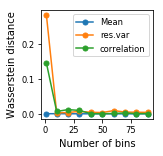

In [47]:
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

plt.figure(figsize=(2, 2))
plt.plot(num_bins_list, [s[0] for s in emd_stats], '-o', ms=5)
plt.plot(num_bins_list, [s[1] for s in emd_stats], '-o', ms=5)
plt.plot(num_bins_list, [s[2] for s in emd_stats], '-o', ms=5)

plt.xlabel('Number of bins'); plt.ylabel('Wasserstein distance')
plt.legend(['Mean', 'res.var', 'correlation'])

plt.savefig(fig_path + 'emd_rv.pdf', bbox_inches='tight')

In [44]:
num_bins=60
binned_stat = stats.binned_statistic(size_factor, size_factor, bins=num_bins, statistic='mean')
bin_idx = np.clip(binned_stat[2], a_min=1, a_max=binned_stat[0].shape[0])
approx_sf = binned_stat[0][bin_idx-1]
max_sf = size_factor.max()
approx_sf[size_factor == max_sf] = max_sf

mean_emd_score = 0
var_emd_score = 0
corr_emd_score = 0

m1, v1 = memento.bootstrap._bootstrap_1d(
    data=sparse_data_1,
    size_factor=approx_sf, 
    num_boot=num_boot,
    q=q,
    _estimator_1d=memento.estimator._hyper_1d_relative)

cov1, v1, v2 = memento.bootstrap._bootstrap_2d(
    data=sp.sparse.hstack([sparse_data_1, sparse_data_2], format='csr'),
    size_factor=approx_sf, 
    num_boot=num_boot,
    q=q,
    _estimator_1d=memento.estimator._hyper_1d_relative,
    _estimator_cov=memento.estimator._hyper_cov_relative)

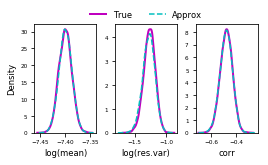

In [46]:
# sns.set_palette('Set2')
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'small',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'xx-small',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)

# sns.reset_defaults()

plt.figure(figsize=(4, 2))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 3, 1)
sns.distplot(np.log(real_boot_mean_dist), hist=False, kde_kws={'linewidth':2, 'color':'m'})
sns.distplot(np.log(m1), hist=False, kde_kws={'linestyle':'--', 'linewidth':1.5, 'color':'c'})
plt.xlabel('log(mean)')
plt.ylabel('Density')

plt.subplot(1, 3, 2)
sns.distplot(np.log(real_boot_var_dist), hist=False, kde_kws={'linewidth':2, 'color':'m'}, label='True')
sns.distplot(np.log(v1/m1**2), hist=False, kde_kws={'linestyle':'--', 'linewidth':1.5, 'color':'c'}, label='Approx')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5,1.2), frameon=False)
plt.xlabel('log(res.var)')

plt.subplot(1, 3, 3)
sns.distplot(real_boot_corr_dist, hist=False, kde_kws={'linewidth':2, 'color':'m'})
sns.distplot(cov1/np.sqrt(v1*v2), hist=False, kde_kws={'linestyle':'--', 'linewidth':1.5, 'color':'c'})
plt.xlabel('corr')
# plt.xlim(-1, 1)

plt.savefig(fig_path + 'approx_bootstrap_dist_rv.pdf', bbox_inches='tight')

### Timing analysis with increasing cell numbers 1D

In [51]:
# Generate cell sizes
num_cells = 5000000
cell_sizes = np.exp(stats.norm.rvs(11, 0.2, num_cells)).astype(int)

# Generate true expression of a single gene
mean = np.median(z_param[0])
variance = np.median(z_param[1])
dispersion = (variance - mean)/mean**2
theta = 1/dispersion
print('mean', mean, 'dispersion', dispersion)

gaussian_variables = stats.multivariate_normal.rvs(cov=[[1, 0.5],[0.5, 1]], size=num_cells)
uniform_variables = stats.norm.cdf(gaussian_variables, loc=0, scale=1)
nbinom_variables = stats.nbinom.ppf(uniform_variables, *simulate.convert_params_nb(mean, theta))

expr_1, expr_2 = nbinom_variables[:, 0], nbinom_variables[:, 1]
expr = expr_1

mean 1.9753069 dispersion 1.8052824161229057


In [52]:
q = 0.07


# Generate the observed distribution
obs_expr_1 = stats.hypergeom.rvs(M=cell_sizes, n=expr_1.astype(int), N=(q*cell_sizes).astype(int))
obs_expr_2 = stats.hypergeom.rvs(M=cell_sizes, n=expr_2.astype(int), N=(q*cell_sizes).astype(int))
obs_expr = obs_expr_1

obs_cell_sizes = (q*cell_sizes).astype(int)

print('unique count', np.unique(obs_expr_1).shape)
print('unique count', np.unique(obs_expr_2).shape)

unique count (9,)
unique count (9,)


In [699]:
imp.reload(bootstrap)
times = []
boot_dists = []
sample_count_list = np.logspace(2, 6, 10)
for sample_count in sample_count_list:
    
    sample_idx = np.random.choice(num_cells, int(sample_count))
    sampled_obs_expr = obs_expr[sample_idx]
    sampled_obs_cell_sizes = obs_cell_sizes[sample_idx]
    
    size_factor = sampled_obs_cell_sizes
    
    # Compute approximate size factor
    num_bins=60
    binned_stat = stats.binned_statistic(size_factor, size_factor, bins=num_bins, statistic='mean')
    bin_idx = np.clip(binned_stat[2], a_min=1, a_max=binned_stat[0].shape[0])
    approx_sf = binned_stat[0][bin_idx-1]
    max_sf = size_factor.max()
    approx_sf[size_factor == max_sf] = max_sf
    
    data = sp.sparse.csc_matrix(sampled_obs_expr.reshape(-1, 1))
    
    times.append(bootstrap._bootstrap_1d(
        data=data,
        size_factor=approx_sf, 
        num_boot=10000,
        q=q,
        return_times=True))
    boot_dists.append(bootstrap._bootstrap_1d(
        data=data,
        q=q,
        size_factor=approx_sf, 
        num_boot=10000, 
        return_times=False))

In [700]:
count_times = [i[1]-i[0] for i in times]
boot_times = [i[2]-i[1] for i in times]
all_times = [i[2]-i[0] for i in times]

In [701]:
all_times

[0.044315338134765625,
 0.07053732872009277,
 0.1139535903930664,
 0.14073681831359863,
 0.176743745803833,
 0.21600079536437988,
 0.2236480712890625,
 0.2624223232269287,
 0.3018481731414795,
 0.4213569164276123]

Text(0, 0.5, 'Runtime (seconds)')

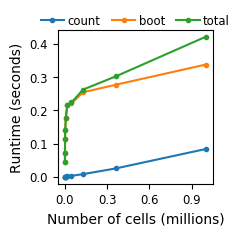

In [702]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)
plt.figure(figsize=(2, 2))

plt.plot(sample_count_list/1e6, count_times, '-o', ms=3)
plt.plot(sample_count_list/1e6, boot_times, '-o', ms=3)
plt.plot(sample_count_list/1e6, all_times, '-o', ms=3)
plt.legend(['count', 'boot', 'total'], loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=3, frameon=False, handletextpad=0.3, columnspacing=1)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.3))
plt.xlabel('Number of cells (millions)'); plt.ylabel('Runtime (seconds)')
# plt.savefig(fig_path + 'bootstrap_runtime.pdf', bbox_inches='tight')

### Confidence intervals

In [634]:
data_2d.shape

(2, 5000)

In [60]:
true_mean_all_cells, true_var_all_cells = memento.estimator._hyper_1d_relative(
    sp.sparse.csc_matrix(obs_expr.reshape(-1, 1)), 
    obs_expr.shape[0], size_factor=obs_cell_sizes, q=q)

true_mean_all_cells_2, true_var_all_cells_2 = memento.estimator._hyper_1d_relative(
    sp.sparse.csc_matrix(obs_expr_2.reshape(-1, 1)), 
    obs_expr.shape[0], size_factor=obs_cell_sizes, q=q)

true_cov_all_cells = memento.estimator._hyper_cov_relative(
    sp.sparse.csc_matrix(np.vstack([obs_expr_1, obs_expr_2]).T), 
    obs_expr.shape[0], size_factor=obs_cell_sizes, q=q,idx1= np.array([0]), idx2=np.array([1]))

true_corr_all_cells = (true_cov_all_cells/np.sqrt(true_var_all_cells_2*true_var_all_cells))[0]

In [61]:
# imp.reload(bootstrap)
times = []
boot_dists = []
boot_dists_2d = []
sample_count_list = [5000, 10000, 50000, 500000, 5000000]
for sample_count in sample_count_list:
    
    sample_idx = np.random.choice(num_cells, int(sample_count))
    sampled_obs_expr = obs_expr[sample_idx]
    sampled_obs_cell_sizes = obs_cell_sizes[sample_idx]
    
    size_factor = sampled_obs_cell_sizes
    
    # Compute approximate size factor
    num_bins=60
    binned_stat = stats.binned_statistic(size_factor, size_factor, bins=num_bins, statistic='mean')
    bin_idx = np.clip(binned_stat[2], a_min=1, a_max=binned_stat[0].shape[0])
    approx_sf = binned_stat[0][bin_idx-1]
    max_sf = size_factor.max()
    approx_sf[size_factor == max_sf] = max_sf
    
    data = sp.sparse.csc_matrix(sampled_obs_expr.reshape(-1, 1))
    data_2d = sp.sparse.csc_matrix(np.vstack([obs_expr_1[sample_idx], obs_expr_2[sample_idx]]).T)
    
    times.append(memento.bootstrap._bootstrap_1d(
        data=data,
        size_factor=approx_sf, 
        num_boot=10000,
        q=q,
        return_times=True,
        _estimator_1d=memento.estimator._hyper_1d_relative))
    boot_dists.append(memento.bootstrap._bootstrap_1d(
        data=data,
        q=q,
        size_factor=approx_sf, 
        num_boot=10000, 
        return_times=False,
        _estimator_1d=memento.estimator._hyper_1d_relative))
    boot_dists_2d.append(memento.bootstrap._bootstrap_2d(
        data=data_2d,
        q=q,
        size_factor=approx_sf,
        num_boot=10000,
        _estimator_1d=memento.estimator._hyper_1d_relative,
        _estimator_cov=memento.estimator._hyper_cov_relative
        ))

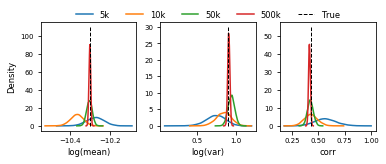

In [62]:
labels = ['5k', '10k', '50k', '500k']
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'small',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'x-small',
         'ytick.labelsize':'x-small'}
pylab.rcParams.update(params)

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.25)

plt.subplot(1, 3, 1)
for idx, sample_count in enumerate(sample_count_list[:-1]):
    sns.distplot(np.log(boot_dists[idx][0]), hist=False)
plt.plot([np.log(true_mean_all_cells), np.log(true_mean_all_cells)], [0, 110], color='k', lw=1, linestyle='--')
plt.xlabel('log(mean)')
plt.ylabel('Density')

plt.subplot(1, 3, 2)
for idx, sample_count in enumerate(sample_count_list[:-1]):
    sns.distplot(np.log(boot_dists[idx][1]/boot_dists[idx][0]**2), hist=False, label=labels[idx])
plt.plot([np.log(true_var_all_cells/true_mean_all_cells**2), np.log(true_var_all_cells/true_mean_all_cells**2)], [0, 30], color='k', lw=1, linestyle='--', label='True')
plt.legend(ncol=5, loc='upper center', bbox_to_anchor=(0.5, 1.18), frameon=False)
plt.xlabel('log(var)')


plt.subplot(1, 3, 3)
for idx, sample_count in enumerate(sample_count_list[:-1]):
    sns.distplot(boot_dists_2d[idx][0]/(np.sqrt(boot_dists_2d[idx][1])*np.sqrt(boot_dists_2d[idx][2])), hist=False)
plt.plot([true_corr_all_cells, true_corr_all_cells], [0, 55], color='k', lw=1, linestyle='--')
plt.xlabel('corr')

plt.savefig(fig_path + 'shrinking_bootstrap_dist_rv.pdf', bbox_inches='tight')

### Validate the bootstrap outcomes for a single gene

Check the mean of the bootstrap distributions for mean and variance

In [297]:
true_data = simulate.simulate_transcriptomes(10000, 2000, correlated=False)
qs, captured_data = simulate.capture_sampling(true_data, q=0.1, q_sq=0.011)
adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
adata.obs['ct'] = 'PBMC'

In [298]:
# Calculate the point estimates
size_factors = scdd.dd_size_factor(adata)
Nr = adata.X.sum(axis=1).mean()
_, M_dd = scdd.dd_1d_moment(adata, size_factor=size_factors, verbose=False, Nr=Nr)
var_scdd = scdd.M_to_var(M_dd)

In [368]:
# Get info for a single gene
gene_idx = 9

data = adata.X[:, gene_idx].todense().A1
sparse_data = adata.X[:, gene_idx]
all_sf = size_factors
normalized_data = data/all_sf/Nr
unique_count = np.unique(data).shape[0]
num_boot = 50000
print('This gene has {} unique counts.'.format(unique_count))

This gene has 59 unique counts.


(array([ 428., 2016., 2990., 2301., 1339.,  615.,  207.,   69.,   26.,
           9.]),
 array([ 1. ,  7.2, 13.4, 19.6, 25.8, 32. , 38.2, 44.4, 50.6, 56.8, 63. ],
       dtype=float32),
 <a list of 10 Patch objects>)

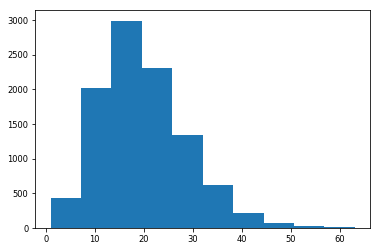

In [369]:
plt.hist(data)

In [370]:
%%time
# Perform true bootstrap
real_boot_mean_dist = np.zeros(num_boot)
real_boot_var_dist = np.zeros(num_boot)
for boot in range(num_boot):
    
    boot_idx = np.random.choice(data.shape[0], data.shape[0])
    res = estimator._poisson_1d(sparse_data[boot_idx], data.shape[0], size_factor=all_sf[boot_idx], n_umi=Nr)
    real_boot_mean_dist[boot] = res[0][0]
    real_boot_var_dist[boot] = res[1][0]

CPU times: user 38.8 s, sys: 0 ns, total: 38.8 s
Wall time: 38.8 s


In [371]:
%%time
imp.reload(bootstrap)
num_bins_list = [5, 10, 30, 60]
approx_boot_dists = []
for num_bins in num_bins_list:

    approx_boot_dists.append(bootstrap._bootstrap_1d(
        data=sparse_data,
        size_factor=all_sf, 
        true_mean=M_dd[0][gene_idx], 
        true_var=var_scdd[gene_idx], 
        num_boot=num_boot, 
        n_umi=Nr, 
        log=False,
        bins=num_bins))  

CPU times: user 3.99 s, sys: 1.25 s, total: 5.24 s
Wall time: 5.24 s


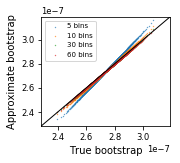

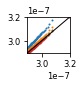

In [380]:
plt.figure(figsize=(2.3, 2))

for idx, num_bins in enumerate(num_bins_list):
    plt.scatter(
        np.quantile(np.sort(real_boot_var_dist), np.linspace(0, 1, 1000)),
        np.quantile(np.sort(approx_boot_dists[idx][1]), np.linspace(0, 1, 1000)),
        label='{} bins'.format(num_bins),
        s=0.1,
    )

plt.plot(np.sort(real_boot_var_dist), np.sort(real_boot_var_dist), lw=1, color='k')
plt.xlim(real_boot_var_dist.min(), real_boot_var_dist.max())
plt.ylim(real_boot_var_dist.min(), real_boot_var_dist.max())
plt.legend()
plt.ylabel('Approximate bootstrap'); plt.xlabel('True bootstrap');
plt.savefig(fig_path + 'bootstrap_ecdf_var_large.pdf', bbox_inches='tight')

plt.figure(figsize=(2.3/3, 2/3))

for idx, num_bins in enumerate(num_bins_list):
    plt.scatter(
        np.quantile(np.sort(real_boot_var_dist), np.linspace(0, 1, 1000)),
        np.quantile(np.sort(approx_boot_dists[idx][1]), np.linspace(0, 1, 1000)),
        label='{} bins'.format(num_bins),
        s=1,
    )
plt.plot(np.sort(real_boot_var_dist), np.sort(real_boot_var_dist), lw=1, color='k')

plt.xlim(2.9e-7, 3.2e-7);
plt.ylim(2.9e-7, 3.2e-7)
plt.savefig(fig_path + 'bootstrap_ecdf_var_small.pdf', bbox_inches='tight')


### Validate the bootstrap outcomes for a single pair of genes

Check the mean of the bootstrap distributions for correlation

In [204]:
true_data = simulate.simulate_transcriptomes(10000, 2000, correlated=True)
qs, captured_data = simulate.capture_sampling(true_data, q=0.1, q_sq=0.011)
adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
adata.obs['ct'] = 'PBMC'

In [268]:
# Get info for a single pair of gene
gene_idx_1 = 0
gene_idx_2 = 3
gene_idxs = [gene_idx_1, gene_idx_2]

data = adata.X[:, gene_idxs].toarray()
sparse_data = adata.X[:, gene_idxs]
all_sf = size_factors
normalized_data = data/all_sf.reshape(-1, 1)/Nr
unique_count = np.unique(data, axis=0).shape[0]
num_boot = 10000
print('This gene has {} unique counts.'.format(unique_count))

This gene has 303 unique counts.


In [269]:
np.unique(data[:, 0]).shape

(8,)

In [270]:
np.unique(data[:, 1]).shape

(90,)

In [271]:
# Calculate the point estimates
size_factors = scdd.dd_size_factor(adata)
Nr = adata.X.sum(axis=1).mean()
true_mean, true_var = estimator._poisson_1d(sparse_data, data.shape[0], size_factor=all_sf, n_umi=Nr)
true_cov = estimator._poisson_cov(sparse_data, data.shape[0], size_factor=all_sf, n_umi=Nr)[0, 1]
true_corr = true_cov/np.sqrt(true_var[0]*true_var[1])

In [272]:
%%time
# Perform true bootstrap
imp.reload(estimator)
real_boot_corr_dist = np.zeros(num_boot)
real_boot_cov_dist = np.zeros(num_boot)

for boot in range(num_boot):
    
    boot_idx = np.random.choice(data.shape[0], data.shape[0])
    boot_mean, boot_var = estimator._poisson_1d(sparse_data[boot_idx], data.shape[0], size_factor=all_sf[boot_idx], n_umi=Nr)
    cov = estimator._poisson_cov(sparse_data[boot_idx], data.shape[0], size_factor=all_sf[boot_idx], n_umi=Nr)[1, 0]
    real_boot_corr_dist[boot] = estimator._corr_from_cov(cov, boot_var[0], boot_var[1])
    real_boot_cov_dist[boot] = cov

CPU times: user 43 s, sys: 1.86 ms, total: 43 s
Wall time: 43 s


In [292]:
%%time
imp.reload(bootstrap)
num_bins_list = [1, 5, 10, 90, 100]
approx_boot_dists = []
for num_bins in num_bins_list:

    approx_boot_dists.append(bootstrap._bootstrap_2d(
        data=sparse_data,
        size_factor=all_sf,
        true_cov=true_cov,
        true_corr=true_corr,
        num_boot=num_boot, 
        n_umi=Nr, 
        bins=num_bins))  


CPU times: user 4.37 s, sys: 1.82 s, total: 6.2 s
Wall time: 6.19 s


### Test distributions of test statistics

In [84]:
num_bins=60
binned_stat = stats.binned_statistic(size_factor, size_factor, bins=num_bins, statistic='mean')
bin_idx = np.clip(binned_stat[2], a_min=1, a_max=binned_stat[0].shape[0])
approx_sf = binned_stat[0][bin_idx-1]
max_sf = size_factor.max()
approx_sf[size_factor == max_sf] = max_sf

mean_emd_score = 0
var_emd_score = 0
corr_emd_score = 0

m1, v1 = memento.bootstrap._bootstrap_1d(
    data=sparse_data_1,
    size_factor=approx_sf, 
    num_boot=num_boot,
    q=q,
    _estimator_1d=memento.estimator._hyper_1d_relative)

m1_1, v1_1 = memento.bootstrap._bootstrap_1d(
    data=sparse_data_1,
    size_factor=approx_sf, 
    num_boot=num_boot,
    q=q,
    _estimator_1d=memento.estimator._hyper_1d_relative)

m2, v2 = memento.bootstrap._bootstrap_1d(
    data=sparse_data_2,
    size_factor=approx_sf, 
    num_boot=num_boot,
    q=q,
    _estimator_1d=memento.estimator._hyper_1d_relative)

m3, v3 = memento.bootstrap._bootstrap_1d(
    data=sparse_data_3,
    size_factor=approx_sf, 
    num_boot=num_boot,
    q=q,
    _estimator_1d=memento.estimator._hyper_1d_relative)

m1 = np.log(m1)
m2 = np.log(m2)
m3 = np.log(m3)
v1 = np.log(v1)
v2 = np.log(v2)
v3 = np.log(v3)

In [85]:
m_diff = m2-m1
v_diff = v2-v1
m_range = np.vstack([m1, m2, m3]).max(axis=0) - np.vstack([m1, m2, m3]).min(axis=0)
v_range = np.vstack([v1, v2, v3]).max(axis=0) - np.vstack([v1, v2, v3]).min(axis=0)

<AxesSubplot:ylabel='Density'>

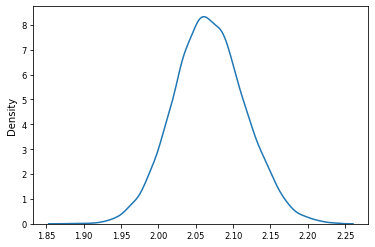

In [86]:
sns.kdeplot(m_range)

In [87]:
from statsmodels.graphics.gofplots import qqplot


In [92]:
stats.anderson(v_diff)

AndersonResult(statistic=0.47849126894652727, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

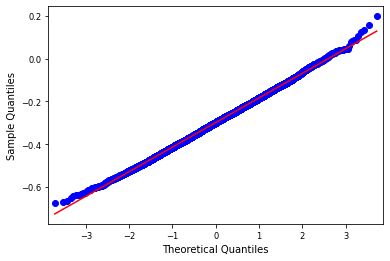

In [93]:
qqplot(v_diff, line='s', lw=1)
plt.show()

In [97]:
m1

array([-7.44253227, -7.4219523 , -7.43075691, ..., -7.41151899,
       -7.42401646, -7.4435877 ])

In [98]:
b = np.vstack([m1, m2, m3])

In [100]:
n = np.array([1, 2, 1])

In [104]:
b * n.reshape(-1, 1)

array([[ -7.44253227,  -7.4219523 ,  -7.43075691, ...,  -7.41151899,
         -7.42401646,  -7.4435877 ],
       [-16.33909126, -16.26095009, -16.38642331, ..., -16.38141814,
        -16.3172283 , -16.29261013],
       [ -9.48670317,  -9.54784477,  -9.54906674, ...,  -9.3947035 ,
         -9.48812475,  -9.47471325]])

In [103]:
b

array([[-7.44253227, -7.4219523 , -7.43075691, ..., -7.41151899,
        -7.42401646, -7.4435877 ],
       [-8.16954563, -8.13047505, -8.19321165, ..., -8.19070907,
        -8.15861415, -8.14630506],
       [-9.48670317, -9.54784477, -9.54906674, ..., -9.3947035 ,
        -9.48812475, -9.47471325]])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

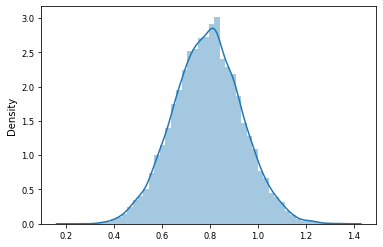

In [96]:
sns.distplot(v_range)